In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from math import floor,ceil,sqrt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
stock_ticker = 'RELIANCE.NS'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.date.today()

In [3]:
df = yf.download(stock_ticker, start = start_date, end = end_date, progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y/%m/%d')
print(df.head())
df.index = df['Date']

YF.download() has changed argument auto_adjust default to True
Price        Date        Open        High         Low       Close      Volume
Ticker            RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
0      2010-01-04  212.289625  212.289625  198.816022  209.254410    76646086
1      2010-01-05  223.730057  223.730057  207.289321  208.320511    21392825
2      2010-01-06  210.110481  212.951136  208.310756  211.686462    23691760
3      2010-01-07  211.686479  216.939721  209.740822  215.198364    26197920
4      2010-01-08  215.577748  216.706230  213.242972  214.634109    15110149


In [4]:
df.dropna(inplace=True)

Text(0.5, 1.0, 'Stock Price over the Years')

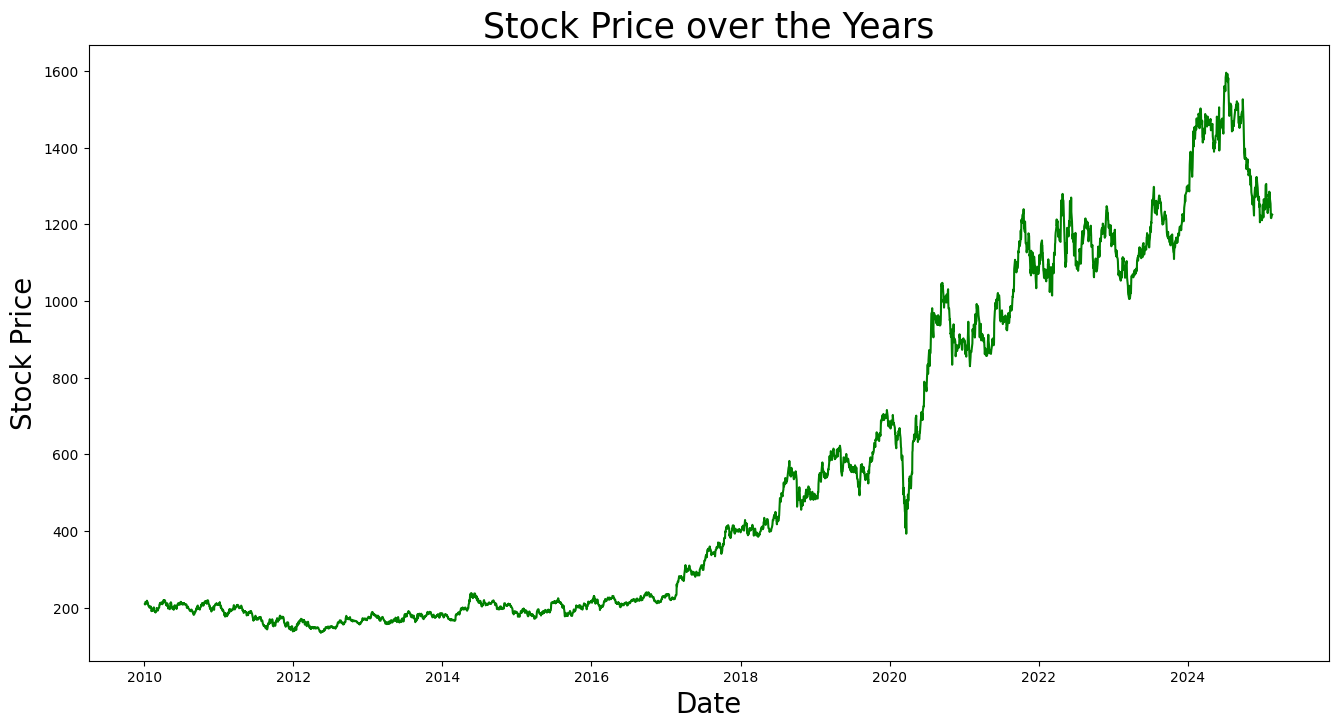

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price over the Years',size=25)

In [6]:
df_new=df[['Close']]
df_new.head()
dataset = df_new.values

In [7]:
shape=df.shape[0]
train=df_new[:ceil(shape*0.75)]
valid=df_new[ceil(shape*0.75):]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
scaleddata = scaler.fit_transform(dataset)

In [10]:
xtrain, ytrain = [], []
for i in range(50,len(train)):
    xtrain.append(scaleddata[i-50:i,0])
    ytrain.append(scaleddata[i,0])

In [11]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],1))

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(50, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(xtrain, ytrain, epochs=20, batch_size=32, validation_split=0.2, callbacks=[earlystopping], verbose=1)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.9506e-05 - val_loss: 0.0012
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 1.3266e-04 - val_loss: 5.7859e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 7.8702e-05 - val_loss: 4.4114e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.0104e-05 - val_loss: 4.2715e-04
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.2179e-05 - val_loss: 4.6201e-04
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.4376e-05 - val_loss: 3.7815e-04
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.1144e-05 - val_loss: 0.0011
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 7.6378e-05 - val_loss: 7.4910e-04
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.5634e-05 - val_loss: 3.2706e-04
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 5.6503e-05 - val_loss: 3

In [15]:
# model.save("model_TATAMOTORS.h5")

In [16]:
# np.save("scaler_TATAMOTORS.npy",scaler)

In [17]:
inputs = df_new[len(df_new) - len(valid) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [18]:
xtest = []
for i in range(50,inputs.shape[0]):
    xtest.append(inputs[i-50:i,0])
xtest = np.array(xtest)
xtest = np.reshape(xtest, (xtest.shape[0],xtest.shape[1],1))

In [19]:
prediction = model.predict(xtest)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


In [20]:
prediction = scaler.inverse_transform(prediction)

In [21]:
mape = mean_absolute_percentage_error(valid, prediction) * 100
print(f"MAPE: {mape}")

MAPE: 2.49270372480977


In [22]:
rmse = np.sqrt(mean_squared_error(valid, prediction))
print(f"RMSE: {rmse}")

RMSE: 38.74247872065063


In [23]:
r2 = r2_score(valid, prediction)
print(f"R² Score: {r2}")

R² Score: 0.9361729025840759


In [24]:
mae = mean_absolute_error(valid, prediction)
print(f"MAE: {mae}")

MAE: 31.18712169965789


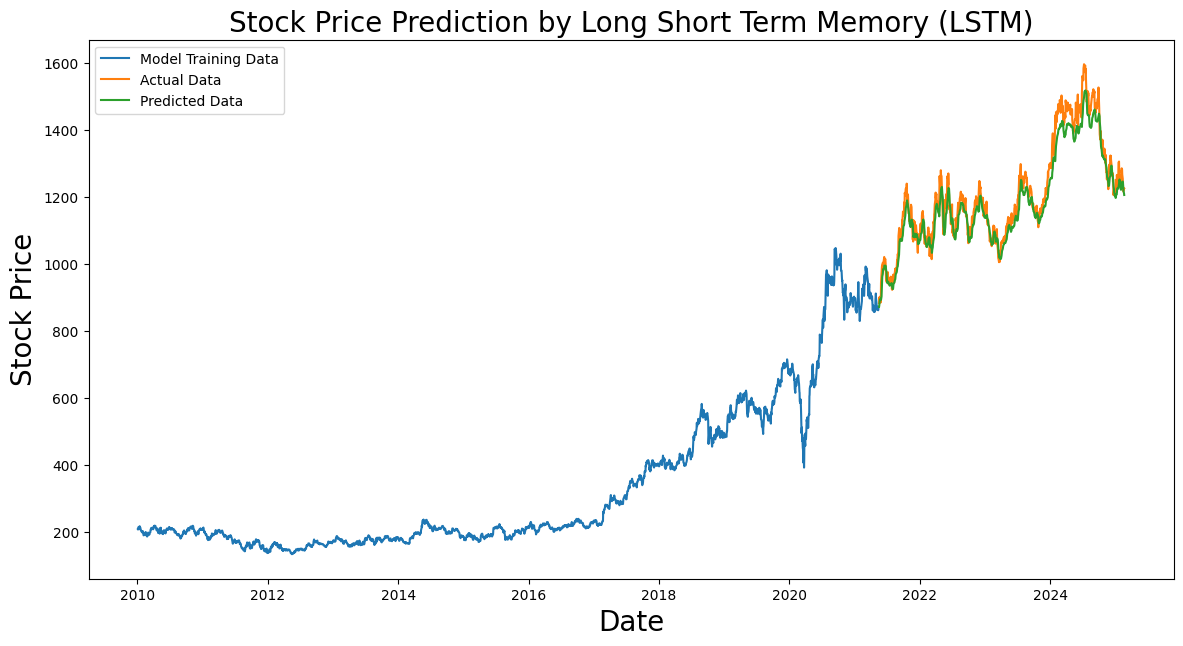

In [25]:
valid['Predictions'] = prediction
plt.figure(figsize=(14, 7))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [26]:
endprice = []
endprice.append(inputs[-50:,0])
endprice = np.array(endprice)
endprice = np.reshape(endprice, (endprice.shape[0],endprice.shape[1],1))
endprice

array([[[0.78279257],
        [0.77231853],
        [0.77913008],
        [0.77601528],
        [0.76026991],
        [0.7657123 ],
        [0.75010381],
        [0.73288666],
        [0.74452454],
        [0.74483257],
        [0.7405882 ],
        [0.74366881],
        [0.73658333],
        [0.73983509],
        [0.7438057 ],
        [0.75787388],
        [0.7642747 ],
        [0.74158081],
        [0.75722347],
        [0.77409842],
        [0.76673917],
        [0.75794232],
        [0.75653889],
        [0.75578587],
        [0.76499346],
        [0.77474874],
        [0.79932523],
        [0.80144741],
        [0.77971196],
        [0.78203955],
        [0.77283196],
        [0.76095449],
        [0.74935079],
        [0.75280796],
        [0.75356098],
        [0.76557542],
        [0.77382457],
        [0.77348228],
        [0.76068064],
        [0.78758464],
        [0.78279257],
        [0.78508599],
        [0.77491989],
        [0.76598615],
        [0.75311599],
        [0

In [27]:
predictedprice = model.predict(endprice)
predictedprice = scaler.inverse_transform(predictedprice)
predictedprice

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[1202.6343]], dtype=float32)